# 다중회귀 vs 다항회귀

### 다중회귀분석 예제: 보스턴 주택 가격 예측

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns=boston.feature_names)

bostonDF['PRICE'] = boston.target
print('Boston 데이터셋 크기:', bostonDF.shape)
bostonDF.head()

Boston 데이터셋 크기: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### 학습과 테스트 데이터 세트로 분리하고 학습/예측/평가 수행

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE: {0:.3f}, RMSE: {1:.3f}'.format(mse, rmse))
print('Varinace score: {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE: 17.297, RMSE: 4.159
Varinace score: 0.757


### intercept와 coefficients를 확인하고 coefficients를 내림차순으로 정렬

In [3]:
print('절편 값:', lr.intercept_)
print('회귀 계수 값:', np.round(lr.coef_, 1))

절편 값: 40.9955951721646
회귀 계수 값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [4]:
coeff = pd.Series(data=np.round(lr.coef_,1), index=X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
B           0.0
TAX        -0.0
AGE         0.0
INDUS       0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

### MSE와 RMSE 측정

In [8]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)
lr = LinearRegression()

neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds의 개별 Nagative MSE scores:', np.round(neg_mse_scores, 2))
print('5 folds의 개별 RMSE scores:',np.round(rmse_scores, 2))
print('5 folds의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 folds의 개별 Nagative MSE scores: [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds의 개별 RMSE scores: [3.53 5.1  5.75 8.99 5.77]
5 folds의 평균 RMSE: 5.829


# 다항회귀로 자동차 연비 예측하기

### 1) 데이터 준비과정

In [10]:
# 기본 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# csv 파일을 데이터프레임으로 변환
df = pd.read_csv('C:/Users/USER/BITAmin/data/auto-mpg.csv')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [11]:
# 열이름 지정
df.columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
             'acceleration', 'model year', 'origin', 'name']

# horsepower열 처리
df['horsepower'].replace('?', np.nan, inplace=True) # '?'을 np.nan으로 변경
df.dropna(subset = ['horsepower'], axis=0, inplace=True) # 누락데이터 행 삭제
df['horsepower'] = df['horsepower'].astype('float') # 문자형을 실수형으로 변환


# 분석에 활용할 열(속성) 선택: 연비, 실린더, 출력, 중량
ndf = df[['mpg', 'cylinders', 'weight']]

### 2) weight를 독립변수, mpg를 종속변수로 설정 후 학습데이터 274개와 테스트 데이터 118개로 분리

In [14]:
# 독립변수와 종속변수로 구분
X = ndf[['weight']]
y = ndf['mpg']

# train/test data로 구분(7:3)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [15]:
print('훈련 데이터: ', X_train.shape)
print('검증 데이터: ', X_test.shape)

훈련 데이터:  (274, 1)
검증 데이터:  (118, 1)


### 3) 비선형 함수인 PolynomialFeatures()의 degree 파라미터를 2로 지정함으로써 2차항 객체인 poly 생성 후, 독립변수 X_train 데이터를 fit_transform 메소드에 전달하여 2차항 변호나

In [22]:
# 필요한 모듈 불러오기
from sklearn.linear_model import LinearRegression # 선형회귀분석
from sklearn.preprocessing import PolynomialFeatures # 다항식 변환

# 다항식변환
poly = PolynomialFeatures(degree=2) # 2차항 적용
X_train_poly = poly.fit_transform(X_train) # X_train 데이터를 2차항으로 변형

print('원본 데이터: ', X_train.shape)
print('2차항 변환 데이터:', X_train_poly.shape)

원본 데이터:  (274, 1)
2차항 변환 데이터: (274, 3)


### 4) LinearRegression() 함수로 선형회귀분석모형 객체를 생성한 후, fit함수를 통해 2차항으로 변환된 훈련데이터를 학습

### 5) 학습 완료 후, 검증데이터를 사용하여 예측 능력 평가: 모형의 결정계수가 높아진 것에서 알 수 있듯이 직선으로 표시된 단순회귀분석에 비해 데이터의 패턴을 더잘 설명

In [24]:
# train data를 가지고 모형 학습
pr = LinearRegression()
pr.fit(X_train_poly, y_train)

# 학습을 마친 모형에 test data를 적용하여 결정계수 계산
X_test_poly = poly.fit_transform(X_test) # X_test 데이터를 2차항으로 변형
r2 = pr.score(X_test_poly, y_test)
print(r2)

0.708700926297548


### 6) 훈련데이터의 분포와 학습된 모형의 회귀선을 그래프로 출력하여 비교

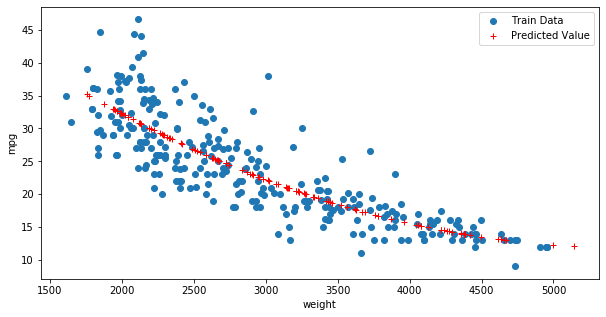

In [25]:
# train data의 산점도와 test data로 예측한 회귀선을 그래프로 출력
# 빨간 '+'들이 예측 결과
y_hat_test = pr.predict(X_test_poly)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1,1,1)
ax.plot(X_train, y_train, 'o', label='Train Data')
ax.plot(X_test, y_hat_test, 'r+', label='Predicted Value')
ax.legend(loc='best')
plt.xlabel('weight')
plt.ylabel('mpg')
plt.show()
plt.close()

# Regularization Method(Shrinkage Method)

### 최적 람다 구하기: cross-validation

- 하이퍼파라미터 람다의 값은 Ridge와 Lasso의 퍼포먼스에 크게 영향을 줌
- GridSearchCV로 람다의 값을 구할 수 있음

In [30]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import validation_curve, train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [32]:
# Ridge + GridSearchCV
ridge = Ridge()
params = {'alpha': np.linspace(0.01, 1.0, 100)} # lambda의 역할과 동일
ridge_cv = GridSearchCV(ridge, params, scoring='r2', cv=5, n_jobs=-1)
ridge_cv.fit(X_train_std, y_train)
opt_r = ridge_cv.best_estimator_
r2_ridge = r2_score(y_test, opt_r.predict(X_test_std))

# Lasso + GridSearchCV
lasso = Lasso()
lasso_cv = GridSearchCV(lasso, params, scoring='r2', cv=5, n_jobs=-1)
lasso_cv.fit(X_train_std, y_train)
opt_l = lasso_cv.best_estimator_
r2_lasso = r2_score(y_test, opt_l.predict(X_test_std))

# Elasticnet + GridSearchCV
elastic = ElasticNet()
elastic_cv = GridSearchCV(elastic, params, scoring='r2', cv=5, n_jobs=-1)
elastic_cv.fit(X_train_std, y_train)
opt_e = elastic_cv.best_estimator_
r2_elastic = r2_score(y_test, opt_e.predict(X_test_std))

print('Ridge R^2 score: {0:.4f}, Lasso R^2 score: {1:.4f}, Elastic R^2 socre: {2:.4f}'.format(r2_ridge,r2_lasso,r2_elastic))

Ridge R^2 score: 0.7839, Lasso R^2 score: 0.7836, Elastic R^2 socre: 0.7833
